# Deep Kernel Learning

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/JuliaGaussianProcesses/KernelFunctions.jl/blob/master/examples/deep-kernel-learning/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/KernelFunctions.jl/dev/examples/deep-kernel-learning/).*

!!! warning
    This example is under construction

Setup

In [1]:
using KernelFunctions
using MLDataUtils
using Zygote
using Flux
using Distributions, LinearAlgebra
using Plots

Flux.@functor SqExponentialKernel
Flux.@functor KernelSum
Flux.@functor Matern32Kernel
Flux.@functor FunctionTransform

set up a kernel with a neural network feature extractor:

In [2]:
neuralnet = Chain(Dense(1, 3), Dense(3, 2))
k = SqExponentialKernel() ∘ FunctionTransform(neuralnet)

Squared Exponential Kernel (metric = Distances.Euclidean(0.0))
	- Function Transform: Chain(Dense(1, 3), Dense(3, 2))

Generate date

In [3]:
xmin = -3;
xmax = 3;
x = range(xmin, xmax; length=100)
x_test = rand(Uniform(xmin, xmax), 200)
x, y = noisy_function(sinc, x; noise=0.1)
X = RowVecs(reshape(x, :, 1))
X_test = RowVecs(reshape(x_test, :, 1))
λ = [0.1]

1-element Vector{Float64}:
 0.1

In [4]:
f(x, k, λ) = kernelmatrix(k, x, X) / (kernelmatrix(k, X) + exp(λ[1]) * I) * y
f(X, k, 1.0)

100-element Vector{Float64}:
 0.13564071872793426
 0.13175108081608616
 0.12641031548805273
 0.11960158647983267
 0.11133618206178593
 0.1016561672870636
 0.09063656930109584
 0.07838699468097192
 0.06505258437940607
 0.05081422184478785
 ⋮
 0.033743065012458384
 0.04656563926638767
 0.058295794164827885
 0.06880540222564249
 0.07800197022833283
 0.08582723506900342
 0.09225512066405511
 0.0972891617749602
 0.10095950570202876

In [5]:
loss(k, λ) = (ŷ -> sum(y - ŷ) / length(y) + exp(λ[1]) * norm(ŷ))(f(X, k, λ))
loss(k, λ)

3.846128046801686

In [6]:
ps = Flux.params(k)

Params([Float32[0.947268; -0.864856; -0.874877], Float32[0.0, 0.0, 0.0], Float32[-0.2724191 -1.0337163 0.047914024; -0.05759289 -0.9832352 -0.027042266], Float32[0.0, 0.0]])

push!(ps,λ)

In [7]:
opt = Flux.Momentum(1.0)

Flux.Optimise.Momentum(1.0, 0.9, IdDict{Any, Any}())

In [8]:
plots = []
for i in 1:10
    grads = Zygote.gradient(() -> loss(k, λ), ps)
    Flux.Optimise.update!(opt, ps, grads)
    p = Plots.scatter(x, y; lab="data", title="Loss = $(loss(k,λ))")
    Plots.plot!(x, f(X, k, λ); lab="Prediction", lw=3.0)
    push!(plots, p)
end

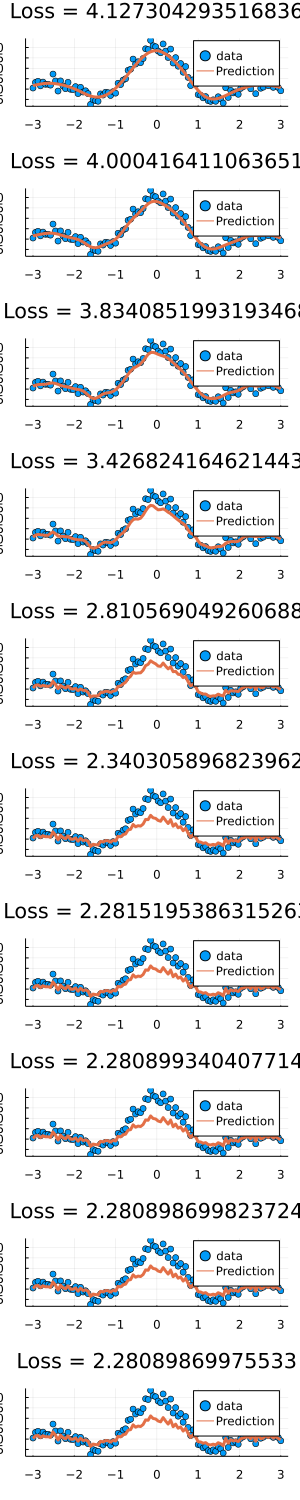

In [9]:
l = @layout grid(10, 1)
plot(plots...; layout=l, size=(300, 1500))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*